# Propagate_Errors

The Propagate_Errors class is aimed to perform the Monte Carlo error propagation in order to quantify the uncertainty
of fitted Gaussian Mixture Model (GMM) parameters. The class permits to estimate the effect of "analytical" uncertainties
 on single observations on GMM results and enables to evaluate the effect of parameters (i.e. n° of observations)
 on the final estimates. The Propagate_Errors assumes input data are normally-distributed, therefore log-transformation of 
 raw data is required.

### Generation of a synthetic sample by means of **GMM** module of PyCO2stats

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyco2stats as PyCO2

# ── Generate a synthetic two‐component GMM sample ────────────────
np.random.seed(0)
true_means   = np.array([0.7, 2.0])
true_stds    = np.array([0.6, 0.4])
true_weights = np.array([0.4, 0.6])

# draw 5000 points from the mixture (log10CO₂ values)
original_sample = PyCO2.GMM.sample_from_gmm(
    n_samples=500,
    means=true_means,
    stds=true_stds,
    weights=true_weights
)

### Fit of the GMM with GMM.gaussian_mixtures_sklearn and su

In [2]:
# ── Propagate a 10% relative measurement error via sklearn‐EM ────
#    This will resample the data 100 times, each time perturbing the log‐values
#    by ~N(0, (0.1 * value)²), then fitting a sklearn GaussianMixture.
n_sim = 100
res = PyCO2.Propagate_Errors.propagate_sklearn_error(
    original_log_data         = original_sample,
    percentage_relative_error = 10.0,
    n_components=2,
    n_simulations             = n_sim,
    max_iter    = 200,    # sklearn EM max iterations
    tol         = 1e-4,   # convergence tolerance
    n_init      = 3,      # number of EM restarts
    covariance_type = 'full',
    suppress_warnings = True,
    show_progress = True
)

# ── 3) Extract results into arrays ───────────────────────────────────
means_sim   = np.vstack(res['means'])      # shape (n_sim, n_components)
stds_sim    = np.vstack(res['std_devs'])   # shape (n_sim, n_components)
weights_sim = np.vstack(res['weights'])    # shape (n_sim, n_components)

# ── 4) Compute summary statistics ────────────────────────────────────
def summarize(mc_samples, label):
    m  = mc_samples.mean(axis=0)
    lo = np.percentile(mc_samples, 2.5, axis=0)
    hi = np.percentile(mc_samples, 97.5, axis=0)
    for i,(mu,l,h) in enumerate(zip(m,lo,hi),1):
        print(f"  {label} comp#{i}: {mu:.2f}  (90% CI: {l:.2f}–{h:.2f})")

print("\nEstimated means after 10% error propagation:")
summarize(means_sim,   "Mean")
print("\nEstimated stds after 10% error propagation:")
summarize(stds_sim,    "StdDev")
print("\nEstimated weights after 10% error propagation:")
summarize(weights_sim, "Weight")



gaussian_mixture_sklearn Monte Carlo: 100%|██████████████████████████████████████████| 100/100 [47:00<00:00, 28.20s/it]


Estimated means after 10% error propagation:
  Mean comp#1: 0.56  (90% CI: 0.51–0.63)
  Mean comp#2: 1.96  (90% CI: 1.94–1.99)

Estimated stds after 10% error propagation:
  StdDev comp#1: 0.56  (90% CI: 0.52–0.60)
  StdDev comp#2: 0.41  (90% CI: 0.39–0.42)

Estimated weights after 10% error propagation:
  Weight comp#1: 0.33  (90% CI: 0.31–0.36)
  Weight comp#2: 0.67  (90% CI: 0.64–0.69)


In [3]:
# ── 4) Compute summary statistics ────────────────────────────────────
def summarize(mc_samples, label):
    m  = np.median(mc_samples, axis=0)
    lo = np.percentile(mc_samples, 2.5, axis=0)
    hi = np.percentile(mc_samples, 97.5, axis=0)
    for i,(mu,l,h) in enumerate(zip(m,lo,hi),1):
        print(f"  {label} comp#{i}: {mu:.2f}  (95% CI: {l:.2f}–{h:.2f})")

print("\nEstimated means after 10% error propagation:")
summarize(means_sim,   "Mean")
print("\nEstimated stds after 10% error propagation:")
summarize(stds_sim,    "StdDev")
print("\nEstimated weights after 10% error propagation:")
summarize(weights_sim, "Weight")



Estimated means after 10% error propagation:
  Mean comp#1: 0.56  (95% CI: 0.51–0.63)
  Mean comp#2: 1.96  (95% CI: 1.94–1.99)

Estimated stds after 10% error propagation:
  StdDev comp#1: 0.56  (95% CI: 0.52–0.60)
  StdDev comp#2: 0.41  (95% CI: 0.39–0.42)

Estimated weights after 10% error propagation:
  Weight comp#1: 0.33  (95% CI: 0.31–0.36)
  Weight comp#2: 0.67  (95% CI: 0.64–0.69)


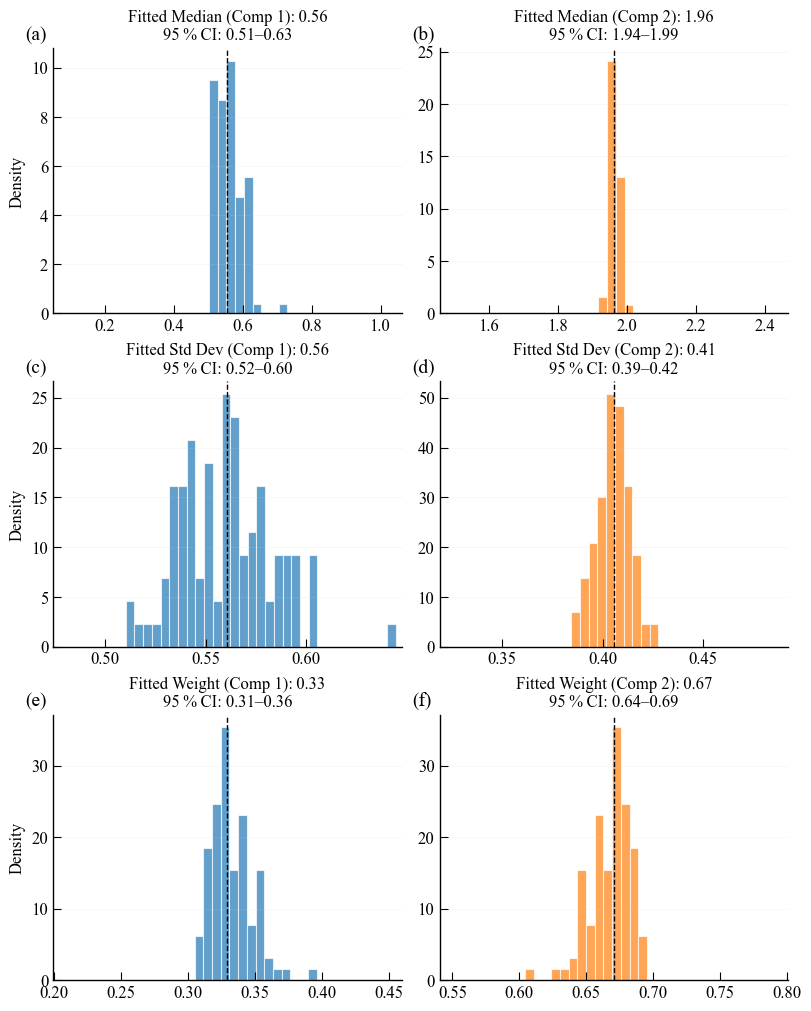

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pyco2stats as PyCO2

def percentile_lims(mc_samples):
    m  = np.median(mc_samples)
    lo = np.percentile(mc_samples,   2.5, axis=0)
    hi = np.percentile(mc_samples,  97.5, axis=0)
    return m, lo, hi

# ── assume your 100×2 arrays are in means_sim, stds_sim, weights_sim

comp_labels = ['Component 1', 'Component 2']
colors      = ['#1f77b4',     '#ff7f0e']

# 1) publication style
plt.rcParams.update({
    'font.family':       'Times New Roman',
    'font.size':         12,
    'axes.linewidth':    1.0,
    'axes.edgecolor':    'black',
    'xtick.direction':   'in',
    'ytick.direction':   'in',
    'xtick.major.size':  6,
    'ytick.major.size':  6,
    'grid.color':        'lightgray',
    'grid.linestyle':    '--',
    'grid.linewidth':    0.5,
    'grid.alpha':        0.3,
})

# 2) common auto‐bins
bins_means   = np.histogram_bin_edges(means_sim.flatten(),   bins=60)
bins_stds    = np.histogram_bin_edges(stds_sim.flatten(),    bins=60)
bins_weights = np.histogram_bin_edges(weights_sim.flatten(), bins=60)

# 3) figure
fig, axs = plt.subplots(3, 2, figsize=(8, 10), constrained_layout=True)

def style_ax(ax):
    ax.grid(axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_dist(ax, data, bins, idx, base_title):
    # compute median & CI
    m, lo, hi = percentile_lims(data[:, idx])
    # histogram
    ax.hist(
        data[:, idx],
        bins=bins,
        density=True,
        color=colors[idx],
        edgecolor='white',
        linewidth=0.8,
        alpha=0.7
    )
    # vertical median line
    ax.axvline(m, color='black', linestyle='--', linewidth=1)
    # dynamic x‐limits just beyond CI
    span = bins[1] - bins[0]
    ax.set_xlim(m - 20*span, m + 20*span)
    # title with median + CI
    ax.set_title(
        f"{base_title} {m:.2f}\n"
        f"95 % CI: {lo:.2f}–{hi:.2f}",
        fontsize=12
    )
    if idx == 0:
        ax.set_ylabel('Density')
    style_ax(ax)

# Means
plot_dist(axs[0,0], means_sim,   bins_means,   0, 'Fitted Median (Comp 1):')
plot_dist(axs[0,1], means_sim,   bins_means,   1, 'Fitted Median (Comp 2):')
# Std‑devs
plot_dist(axs[1,0], stds_sim,    bins_stds,    0, 'Fitted Std Dev (Comp 1):')
plot_dist(axs[1,1], stds_sim,    bins_stds,    1, 'Fitted Std Dev (Comp 2):')
# Weights
plot_dist(axs[2,0], weights_sim, bins_weights, 0, 'Fitted Weight (Comp 1):')
plot_dist(axs[2,1], weights_sim, bins_weights, 1, 'Fitted Weight (Comp 2):')

# 4) Panel letters
for ax, letter in zip(axs.flat, ['(a)','(b)','(c)','(d)','(e)','(f)']):
    ax.text(-0.08, 1.02, letter,
            transform=ax.transAxes,
            fontsize=14, fontweight='normal', va='bottom')

plt.tight_layout
plt.savefig("montecarlo_error_prop.png", dpi=300, bbox_inches='tight')
plt.show()
